In [1]:
import numpy as np
import xgboost as xgb
import pickle
import os
import gc
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import json

from utilities import (
    RANDOM_STATE, TARGET_COL, N_FOLD, FOLD_STRAT_NAME,
    PARAMS_XGB_GPU_BASE
)

INPUT_PATH = '../input/tabular-playground-series-oct-2021'
PATH_NOTEBOOK = '../input/preprocess-gpu'
PATH_PARAM = '../input/optuna-xgboost'

In [2]:
train = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'train_unscaled.pkl')
)

In [3]:
with open(os.path.join(PATH_NOTEBOOK, 'feature_dic.pkl'), 'rb') as file:
    feature_dic = pickle.load(file)

In [4]:
#CONSTANT
FEATURE = feature_dic['feature']
CAT_COL = feature_dic['categorical']
NUMERIC_COL = feature_dic['numerical']

FOLD_LIST = range(train[FOLD_STRAT_NAME].nunique())

gc.collect()

30

In [5]:
params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
    'seed': RANDOM_STATE,
    "learning_rate": .005,
}

#import lgb optimized parameter (file_name is wrong :()
with open(os.path.join(PATH_PARAM, 'final_xgb_param.pkl'), 'rb') as file:
    param_xgb_final = pickle.load(file)

params.update(param_xgb_final)

#pretty print
print(json.dumps(params, indent=4))


{
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "seed": 383920,
    "learning_rate": 0.005,
    "subsample": 0.8081548613972851,
    "colsample_bytree": 0.5093883996922348,
    "lambda": 6.593897401079495,
    "alpha": 8.220939046693244,
    "max_depth": 4,
    "gamma": 0.9917294458236702
}


# TRAIN

In [6]:
score = 0
model_list = []

prediction_df = pd.DataFrame(
    {
        'fold': train[FOLD_STRAT_NAME],
        'prediction': np.zeros((train.shape[0]))
    }
)


for i, fold_ in enumerate(FOLD_LIST):

    mask_train = (train[FOLD_STRAT_NAME] != fold_)
    mask_test = (train[FOLD_STRAT_NAME] == fold_)
    
    
    train_x, train_y = train.loc[mask_train, FEATURE], train.loc[mask_train, TARGET_COL]
    test_x, test_y = train.loc[mask_test, FEATURE], train.loc[mask_test, TARGET_COL]

    model = xgb.train(params = params ,
                      dtrain = xgb.DMatrix(train_x, train_y), num_boost_round = 100000,
                      evals =[(xgb.DMatrix(test_x, test_y),'valid')],
                      verbose_eval = 500, early_stopping_rounds = 500)
    
    #oof prediction
    prediction_df.loc[mask_test, 'prediction'] = model.predict(xgb.DMatrix(test_x))

    #evaluate score and save model for importance/prediction
    score_fold = model.best_score 
    score += score_fold/N_FOLD
    
    model_list.append(model)
    
    print('\nFold: {}; Auc: {:.5f}\n'.format(fold_, score_fold))
    print('-'*50)
    print('\n\n\n')
    gc.collect()
    
print('CV-Auc: {:.5f}\n'.format(score))

[0]	valid-auc:0.63719
[500]	valid-auc:0.83449
[1000]	valid-auc:0.83923
[1500]	valid-auc:0.84347
[2000]	valid-auc:0.84635
[2500]	valid-auc:0.84840
[3000]	valid-auc:0.84990
[3500]	valid-auc:0.85108
[4000]	valid-auc:0.85201
[4500]	valid-auc:0.85278
[5000]	valid-auc:0.85342
[5500]	valid-auc:0.85396
[6000]	valid-auc:0.85441
[6500]	valid-auc:0.85479
[7000]	valid-auc:0.85511
[7500]	valid-auc:0.85541
[8000]	valid-auc:0.85567
[8500]	valid-auc:0.85589
[9000]	valid-auc:0.85609
[9500]	valid-auc:0.85626
[10000]	valid-auc:0.85641
[10500]	valid-auc:0.85655
[11000]	valid-auc:0.85666
[11500]	valid-auc:0.85676
[12000]	valid-auc:0.85686
[12500]	valid-auc:0.85694
[13000]	valid-auc:0.85701
[13500]	valid-auc:0.85708
[14000]	valid-auc:0.85713
[14500]	valid-auc:0.85718
[15000]	valid-auc:0.85722
[15500]	valid-auc:0.85725
[16000]	valid-auc:0.85729
[16500]	valid-auc:0.85732
[17000]	valid-auc:0.85734
[17500]	valid-auc:0.85736
[18000]	valid-auc:0.85738
[18500]	valid-auc:0.85739
[19000]	valid-auc:0.85741
[19500]	va

# Feature importance

In [7]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = FEATURE


for fold_, model in enumerate(model_list):
    imp_dict = model.get_score(importance_type="total_gain")
    imp_temp = [imp_dict[x] if x in imp_dict.keys() else 0 for x in FEATURE]
    
    feature_importances['fold_{}'.format(fold_ + 1)] = imp_temp

Text(0.5, 1.0, '50 TOP feature importance over 5 average')

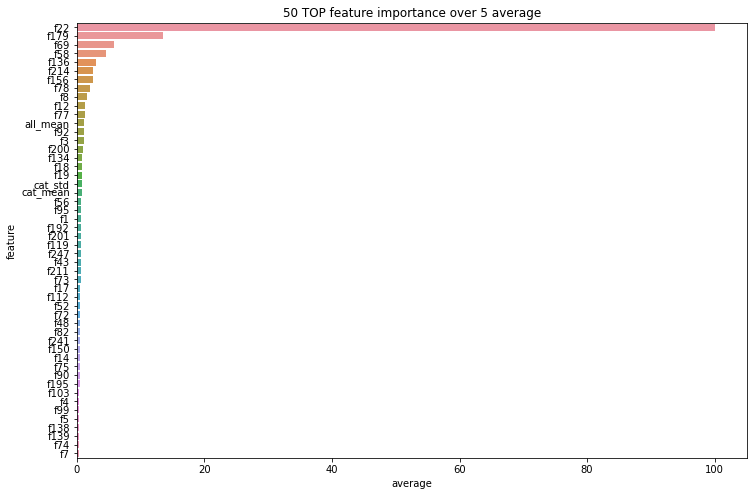

In [8]:
scaler = MinMaxScaler(feature_range=(0, 100))

average_importance = feature_importances.drop('feature', axis = 1).mean(axis=1)

feature_importances['average'] = scaler.fit_transform(X=pd.DataFrame(average_importance))
feature_importances = feature_importances.sort_values(by='average', ascending=False)

feature_importances[['feature', 'average']].to_csv('feature_importances.csv',index=False)

fig = plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.head(50), x='average', y='feature');
plt.title(f'50 TOP feature importance over {N_FOLD} average')

# TEST Blending

In [9]:
del train
gc.collect()

36

In [10]:
test = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'test_unscaled.pkl')
)

In [11]:
pred_test = np.zeros(test.shape[0])

for fold_, model in enumerate(model_list):
    pred_test += model.predict(xgb.DMatrix(test))/N_FOLD

# SAVE RESULT

In [12]:
submission = pd.read_csv(os.path.join(INPUT_PATH, 'sample_submission.csv'))
submission['target'] = pred_test

submission.to_csv('submission.csv', index = False)

In [13]:
prediction_df.to_csv('oof_prediction', index = False)